# Cohort analysis implementation in Python

### Tasks:

- How many orders on average and for how much money all cohorts make in the first year?
- Compare any two cohorts in terms of profit and number of orders?

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [29]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')

Build the cohorts on the purchase date (order_purchase_timestamp), so convert it to datetime64. 
Let's create an order_id index and connect our datasets by it.

In [30]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_payments = df_payments.set_index('order_id')
df_orders = df_orders.set_index('order_id')
order_payment = df_orders.join(df_payments)

Need monthly cohorts, so I will be looking at the overall behaviour of our customers for the month. 
So don't need detailed order_purchase_timestamp data.

In [31]:
order_payment.reset_index(inplace=True)
order_payment['Period'] = order_payment.order_purchase_timestamp.dt.strftime('%Y-%m')

Let's create a new column CohortGroup, which is the year and month when the first delivery of the order to the customer occurred.

In [58]:
order_payment.set_index('customer_id', inplace=True)
order_payment['CohortGroup'] = order_payment.groupby(level=0)['order_purchase_timestamp'].min().dt.strftime('%Y-%m')#.dt.apply(lambda x: x.strftime('%Y-%m'))
order_payment.reset_index(inplace=True)

Considering monthly cohorts, we need to aggregate customers, purchases and purchase amounts for each CohortGroup during the month (Period).

In [59]:
grouped = order_payment.groupby(['CohortGroup', 'Period'])

cohorts = grouped.agg({'customer_id': pd.Series.nunique,
                        'payment_value': 'sum',
                        'order_id': 'count'})

cohorts.rename(columns={'customer_id': 'TotalClients',
                         'order_id': 'TotalOrders'}, inplace=True)

Considering monthly cohorts, it needs to aggregate customers, purchases and purchase amounts for each CohortGroup during the month (Period).

In [60]:
grouped = order_payment.groupby(['CohortGroup', 'Period'])
cohorts = grouped.agg({'customer_id': pd.Series.nunique,
                        'payment_value': 'sum',
                        'order_id': 'count'})

cohorts.rename(columns={'customer_id': 'TotalClients',
                         'order_id': 'TotalOrders'}, inplace=True)

To see how each cohort behaved in the months after their first purchase, so it should index each cohort to their first month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second and so on. This allows us to compare cohorts at different stages of their lives

In [61]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

print(cohorts.head(10))
print(cohorts.tail(12))

                     TotalClients  payment_value  TotalOrders  CohortPeriod
CohortGroup Period                                                         
2016-09     2016-09             4         252.24            4             1
2016-10     2016-10           324       59090.48          342             1
2016-12     2016-12             1          19.62            1             1
2017-01     2017-01           800      138488.04          850             1
2017-02     2017-02          1780      291908.01         1886             1
2017-03     2017-03          2682      449863.60         2837             1
2017-04     2017-04          2404      417788.03         2571             1
2017-05     2017-05          3700      592918.82         3944             1
2017-06     2017-06          3245      511276.38         3436             1
2017-07     2017-07          4026      592382.92         4317             1
                     TotalClients  payment_value  TotalOrders  CohortPeriod
CohortGroup 

To compare cohorts based on these results. For example cohort 2018-06 and 2018-07: The total number of customers and purchases increased. But, let's count the purchases per customer:
2018-06 - 6419/6167 = 1.04
2018-07 - 6507/6292 = 1.03
#### Conclusion: on average, customers have started buying less frequently.

In [62]:
purchase_count = df_orders.groupby('customer_id').size().reset_index(name='purchase_count')
print(purchase_count.head())

                        customer_id  purchase_count
0  00012a2ce6f8dcda20d059ce98491703               1
1  000161a058600d5901f007fab4c27140               1
2  0001fd6190edaaf884bcaf3d49edf079               1
3  0002414f95344307404f0ace7a26f1d5               1
4  000379cdec625522490c315e70c7a9fb               1


Calculate the average number of orders, customers and average amount for each year.

In [63]:
cohorts = cohorts.reset_index()
cohorts['CohortGroupYear'] = cohorts['CohortGroup'].apply(lambda x: x.split('-')[0])
tt = cohorts.groupby('CohortGroupYear').agg({'payment_value': 'mean','TotalOrders':'mean','TotalClients':'mean'})
tt['ratio'] = tt['TotalOrders'] / tt['TotalClients']
print(tt)

                 payment_value  TotalOrders  TotalClients     ratio
CohortGroupYear                                                    
2016              19787.446667   115.666667    109.666667  1.054711
2017             604145.560833  3960.416667   3758.416667  1.053746
2018             869976.305000  5601.500000   5401.100000  1.037104


### Conclusion: During the analysis of the 2016 data, it was found that only 3-month data with unusual values were available. For 2018, purchase data are available for only 10 months. Despite this, there is an increase in activity in 2018 compared to 2017, but the average number of purchases per customer is decreasing.

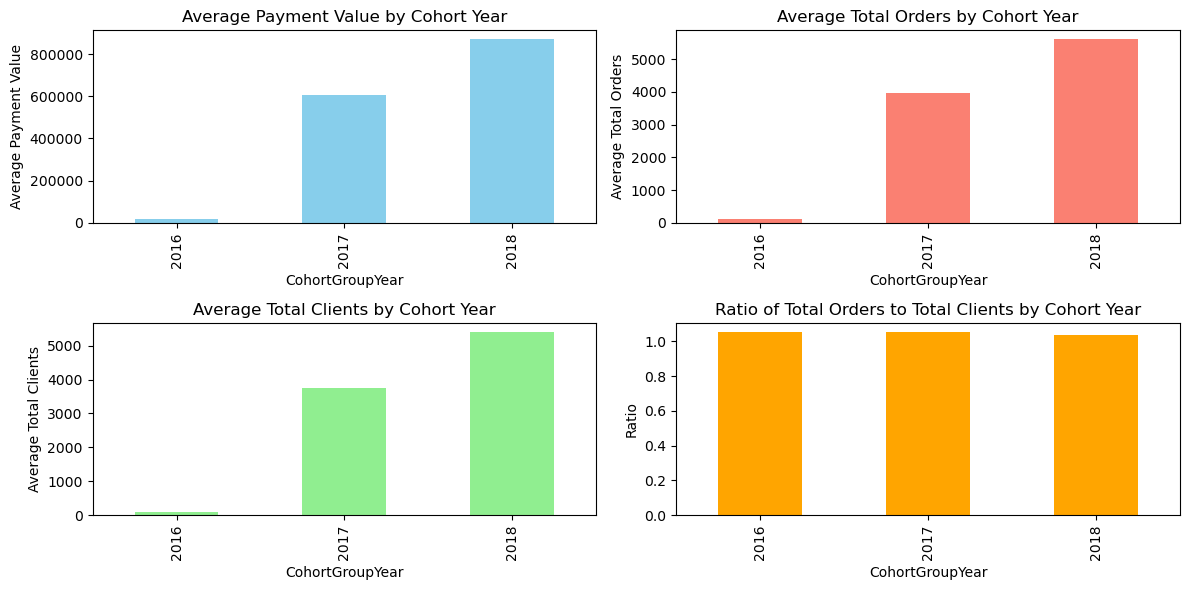

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Graph of average 'payment_value' by years of cohort
plt.subplot(2, 2, 1)
tt['payment_value'].plot(kind='bar', color='skyblue')
plt.title('Average Payment Value by Cohort Year')
plt.ylabel('Average Payment Value')

# Graph of average 'TotalOrders' by years of cohort
plt.subplot(2, 2, 2)
tt['TotalOrders'].plot(kind='bar', color='salmon')
plt.title('Average Total Orders by Cohort Year')
plt.ylabel('Average Total Orders')

# Graph of average 'TotalClients' by years of cohort
plt.subplot(2, 2, 3)
tt['TotalClients'].plot(kind='bar', color='lightgreen')
plt.title('Average Total Clients by Cohort Year')
plt.ylabel('Average Total Clients')

# Graph of 'TotalOrders' to 'TotalClients' by years cohort
plt.subplot(2, 2, 4)
tt['ratio'].plot(kind='bar', color='orange')
plt.title('Ratio of Total Orders to Total Clients by Cohort Year')
plt.ylabel('Ratio')

plt.tight_layout()
plt.show()
